In [1]:
import cv2
import numpy as np
import os
from scipy.optimize import least_squares
from tomlkit import boolean
from tqdm import tqdm
import matplotlib.pyplot as plt

from hw3_defs import get_all_matches, normalize_images, grayscale_images, find_features

In [2]:
import sys
from os import path as os_path
file_path = os_path.dirname(os_path.realpath(''))
img_dir = file_path + "/HW4/buddha_images"

# I don't want to downscale images???
downscale_factor = 1.0

# Camera intrinsics
K = np.array([[1600.0, 0.0, 960.0],
              [0.0, 1600.0, 540.0],
              [0.0,0.0,1.0]])

image_list = []
for image in sorted(os.listdir(img_dir)):
    if image[-4:].lower() == '.jpg' or image[-4:].lower() == '.png':
        image_list.append(img_dir + '/' + image)

imgs = []
for file_path1 in image_list: 
    imgs.append(cv2.imread(file_path1))

imgs_norm = normalize_images(imgs)
imgs_gray = grayscale_images(imgs_norm)

In [3]:
feature_matches = get_all_matches(imgs, print_matches=False)


In [4]:

def optimal_reprojection_error(obj_points) -> np.array:
    '''
    calculates of the reprojection error during bundle adjustment
    returns error 
    '''
    transform_matrix = obj_points[0:12].reshape((3,4))
    K = obj_points[12:21].reshape((3,3))
    rest = int(len(obj_points[21:]) * 0.4)
    p = obj_points[21:21 + rest].reshape((2, int(rest/2))).T
    obj_points = obj_points[21 + rest:].reshape((int(len(obj_points[21 + rest:])/3), 3))
    rot_matrix = transform_matrix[:3, :3]
    tran_vector = transform_matrix[:3, 3]
    rot_vector, _ = cv2.Rodrigues(rot_matrix)
    image_points, _ = cv2.projectPoints(obj_points, rot_vector, tran_vector, K, None)
    image_points = image_points[:, 0, :]
    error = [ (p[idx] - image_points[idx])**2 for idx in range(len(p))]
    return np.array(error).ravel()/len(p)

def bundle_adjustment(_3d_point, opt, transform_matrix_new, K, r_error) -> tuple:
    '''
    Bundle adjustment for the image and object points
    returns object points, image points, transformation matrix
    '''
    opt_variables = np.hstack((transform_matrix_new.ravel(), K.ravel()))
    opt_variables = np.hstack((opt_variables, opt.ravel()))
    opt_variables = np.hstack((opt_variables, _3d_point.ravel()))

    values_corrected = least_squares(optimal_reprojection_error, opt_variables, gtol = r_error).x
    K = values_corrected[12:21].reshape((3,3))
    rest = int(len(values_corrected[21:]) * 0.4)
    return values_corrected[21 + rest:].reshape((int(len(values_corrected[21 + rest:])/3), 3)), values_corrected[21:21 + rest].reshape((2, int(rest/2))).T, values_corrected[0:12].reshape((3,4))

def to_ply(path, point_cloud, colors) -> None:
    '''
    Generates the .ply which can be used to open the point cloud
    '''
    out_points = point_cloud.reshape(-1, 3) * 200
    out_colors = colors.reshape(-1, 3)
    print(out_colors.shape, out_points.shape)
    verts = np.hstack([out_points, out_colors])


    mean = np.mean(verts[:, :3], axis=0)
    scaled_verts = verts[:, :3] - mean
    dist = np.sqrt(scaled_verts[:, 0] ** 2 + scaled_verts[:, 1] ** 2 + scaled_verts[:, 2] ** 2)
    indx = np.where(dist < np.mean(dist) + 300)
    verts = verts[indx]
    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar blue
        property uchar green
        property uchar red
        end_header
        '''
    with open(path + '/HW4/res1/' + 'myPC1.ply', 'w') as f:
        f.write(ply_header % dict(vert_num=len(verts)))
        np.savetxt(f, verts, '%f %f %f %d %d %d')

In [5]:
enable_bundle_adjustment = False

# Find Feature Matches

In [6]:
transform_matrix_0 = np.eye(4)[:3,:]
pose_array = []

pose_0 = np.matmul(K, transform_matrix_0)
pose_1 = np.empty((3, 4)) 
total_points = np.zeros((1, 3))
total_colors = np.zeros((1, 3))

feature_0, feature_1 = feature_matches[0]

# Find Essential Matrix

In [7]:
def get_essential_matrix(points1, points2):
    # Essential matrix
    essential_matrix, em_mask = cv2.findEssentialMat(points1, points2, K, method=cv2.RANSAC, prob=0.999, threshold=0.4, mask=None)
    # Only keep inlier points
    points1 = feature_0[em_mask.ravel() == 1]
    points2 = feature_1[em_mask.ravel() == 1]

    return essential_matrix, em_mask, (points1, points2)

In [8]:
essential_matrix, em_mask, (feature_0, feature_1) = get_essential_matrix(feature_0, feature_1)

# Recover Pose
Recover Pose from the essential matrix using cv2.recoverPose.<br>
This method returns triangulated 3D points that pass the cheirality check

In [9]:
def get_pose(essential_matrix, em_mask, pts1, pts2):
    _, rot_matrix, tran_matrix, em_mask = cv2.recoverPose(essential_matrix, pts1, pts2, K)

    transformation_matrix = np.hstack((rot_matrix, tran_matrix))

    # Apply Cheirality check to points
    f_pts1 = pts1[em_mask.ravel() > 0]
    f_pts2 = pts2[em_mask.ravel() > 0]

    return transformation_matrix, f_pts1, f_pts2

In [10]:
transformation_matrix_1, feature_0, feature_1 = get_pose(essential_matrix, em_mask, feature_0, feature_1)

# Triangulation

In [11]:
def triangulation(point_2d_1, point_2d_2, projection_matrix_1, projection_matrix_2) -> tuple:
    '''
    Triangulates 3d points from 2d vectors and projection matrices
    returns projection matrix of first camera, projection matrix of second camera, point cloud 
    '''
    pt_cloud = cv2.triangulatePoints(point_2d_1, point_2d_2, projection_matrix_1.T, projection_matrix_2.T)
    return projection_matrix_1.T, projection_matrix_2.T, (pt_cloud / pt_cloud[3])    


In [12]:
pose_1 = np.matmul(K, transformation_matrix_1)

feature_0_new, feature_1_new, points_3d = triangulation(pose_0, pose_1, feature_0, feature_1)

In [13]:
print(pose_1)

[[ 1.54201620e+03 -8.13359448e+00  1.05058073e+03 -1.51695585e+03]
 [-1.18387598e+01  1.60551284e+03  5.23247888e+02 -3.68912145e+00]
 [-5.75199102e-02  1.05677918e-02  9.98288426e-01 -8.53347898e-01]]


# Reprojection Error

In [14]:
def reprojection_error(obj_points, image_points, transform_matrix, K, homogenity) ->tuple:
    '''
    Calculates the reprojection error ie the distance between the projected points and the actual points.
    returns total error, object points
    '''
    rot_matrix = transform_matrix[:3, :3]
    tran_vector = transform_matrix[:3, 3]
    rot_vector, _ = cv2.Rodrigues(rot_matrix)
    if homogenity == 1:
        obj_points = cv2.convertPointsFromHomogeneous(obj_points.T)
    image_points_calc, _ = cv2.projectPoints(obj_points, rot_vector, tran_vector, K, None)
    image_points_calc = np.float32(image_points_calc[:, 0, :])
    total_error = cv2.norm(image_points_calc, np.float32(image_points.T) if homogenity == 1 else np.float32(image_points), cv2.NORM_L2)
    return total_error / len(image_points_calc), obj_points

In [15]:
error, points_3d_new = reprojection_error(points_3d, feature_1_new, transformation_matrix_1, K, homogenity = 1)
#ideally error < 1
print("REPROJECTION ERROR: ", error)

REPROJECTION ERROR:  0.008641457787073108


# PnP

In [16]:
def PnP(obj_point, image_point , K, dist_coeff, rot_vector, initial) ->  tuple:
    '''
    Finds an object pose from 3D-2D point correspondences using the RANSAC scheme.
    returns rotational matrix, translational matrix, image points, object points, rotational vector
    '''
    if initial == 1:
        obj_point = obj_point[:, 0 ,:]
        image_point = image_point.T
        rot_vector = rot_vector.T 
    
    _, rot_vector_calc, tran_vector, inlier = cv2.solvePnPRansac(obj_point, image_point, K, dist_coeff, cv2.SOLVEPNP_ITERATIVE)
    # Converts a rotation matrix to a rotation vector or vice versa
    rot_matrix, _ = cv2.Rodrigues(rot_vector_calc)

    if inlier is not None:
        image_point = image_point[inlier[:, 0]]
        obj_point = obj_point[inlier[:, 0]]
        rot_vector = rot_vector[inlier[:, 0]]
    return np.hstack((rot_matrix, tran_vector)), image_point, obj_point, rot_vector

In [17]:
_, feature_1_pnp, points_3d_pnp, _ = PnP(points_3d_new, feature_1_new, K, np.zeros((5, 1), dtype=np.float32), feature_0_new, initial=1)

# Loop for all Images

In [18]:
def common_points(image_points_1, image_points_2, image_points_3) -> tuple:
    '''
    Finds the common points between image 1 and 2 , image 2 and 3
    returns common points of image 1-2, common points of image 2-3, mask of common points 1-2 , mask for common points 2-3 
    '''
    cm_points_1 = []
    cm_points_2 = []
    for i in range(image_points_1.shape[0]):
        a = np.where(image_points_2 == image_points_1[i, :])
        if a[0].size != 0:
            cm_points_1.append(i)
            cm_points_2.append(a[0][0])

    mask_array_1 = np.ma.array(image_points_2, mask=False)
    mask_array_1.mask[cm_points_2] = True
    mask_array_1 = mask_array_1.compressed()
    mask_array_1 = mask_array_1.reshape(int(mask_array_1.shape[0] / 2), 2)

    mask_array_2 = np.ma.array(image_points_3, mask=False)
    mask_array_2.mask[cm_points_2] = True
    mask_array_2 = mask_array_2.compressed()
    mask_array_2 = mask_array_2.reshape(int(mask_array_2.shape[0] / 2), 2)
    print(" Shape New Array", mask_array_1.shape, mask_array_2.shape)
    return np.array(cm_points_1), np.array(cm_points_2), mask_array_1, mask_array_2

In [19]:
feature_0_loop = feature_0_new
feature_1_loop = feature_1_pnp
points_3d_loop = points_3d_pnp

total_images = len(image_list) - 2 
pose_array = []
pose_array.append(np.vstack((transformation_matrix_1,[0,0,0,1]))) #np.vstack((pose_0, [0,0,0,1])))
pose_array.append(np.vstack((transformation_matrix_1,[0,0,0,1])))#np.vstack((pose_1, [0,0,0,1])))

points_3d_array = []
points_3d_array.append(points_3d_loop)

transform_matrix_0 = np.copy(transformation_matrix_1)


transformation_matrices = []
transformation_matrices.append(transform_matrix_0)

threshold = 0.5
for i in tqdm(range(total_images)):
    # Find and Match Features
    features_cur, features_2 = feature_matches[i+1]
    
    if i != 0:
        # Perform Triangulation to get 3D points
        feature_0_loop, feature_1_loop, points_3d_loop = triangulation(pose_0, pose_1, feature_0_loop, feature_1_loop)
        feature_1_loop = feature_1_loop.T
        points_3d_loop = cv2.convertPointsFromHomogeneous(points_3d_loop.T)
        points_3d_loop = points_3d_loop[:, 0, :]
    
    # Finds common points between images
    cm_points_0, cm_points_1, cm_mask_0, cm_mask_1 = common_points(feature_1_loop, features_cur, features_2)
    cm_points_2 = features_2[cm_points_1]
    cm_points_cur = features_cur[cm_points_1]

    # Performs PnP
    transform_matrix_1, cm_points_2, points_3d_loop, cm_points_cur = PnP(points_3d_loop[cm_points_0], cm_points_2, K, np.zeros((5, 1), dtype=np.float32), cm_points_cur, initial = 0)
    pose_2 = np.matmul(K, transform_matrix_1)

    error, points_3d_loop = reprojection_error(points_3d_loop, cm_points_2, transform_matrix_1, K, homogenity = 0)

    
    cm_mask_0, cm_mask_1, points_3d_loop = triangulation(pose_1, pose_2, cm_mask_0, cm_mask_1)
    error, points_3d_loop = reprojection_error(points_3d_loop, cm_mask_1, transform_matrix_1, K, homogenity = 1)
    print("Reprojection Error: ", error)

    pose_array.append(np.vstack((transform_matrix_1,[0,0,0,1])).dot(np.vstack((transform_matrix_0,[0,0,0,1]))))#np.vstack((pose_2, [0,0,0,1])))
    points_3d_array.append(points_3d_loop[:, 0, :])

    # takes a long time to run
    if enable_bundle_adjustment:
        points_3d_loop, cm_mask_1, transform_matrix_1 = bundle_adjustment(points_3d_loop, cm_mask_1, transform_matrix_1, K, threshold)
        pose_2 = np.matmul(K, transform_matrix_1)
        error, points_3d_loop = reprojection_error(points_3d_loop, cm_mask_1, transform_matrix_1, K, homogenity = 0)
        print("Bundle Adjusted error: ",error)
        total_points = np.vstack((total_points, points_3d_loop))
        points_left = np.array(cm_mask_1, dtype=np.int32)
        color_vector = np.array([imgs[i+2][l[1], l[0]] for l in points_left])
        total_colors = np.vstack((total_colors, color_vector))
    else:
        total_points = np.vstack((total_points, points_3d_loop[:, 0, :]))
        points_left = np.array(cm_mask_1, dtype=np.int32)
        color_vector = np.array([imgs[i+2][l[1], l[0]] for l in points_left.T])
        total_colors = np.vstack((total_colors, color_vector)) 

    

    transformation_matrices.append(transform_matrix_1)


    transform_matrix_0 = np.copy(transform_matrix_1)
    pose_0 = np.copy(pose_1)
    # plt.scatter(i, error)
    # plt.pause(0.05)

    feature_0_loop = np.copy(features_cur)
    feature_1_loop = np.copy(features_2)
    pose_1 = np.copy(pose_2)
    #cv2.imshow(img_obj.image_list[0].split('/')[-2], image_2)
    # if cv2.waitKey(1) & 0xff == ord('q'):
    #     break

print("Printing to .ply file")
print(total_points.shape, total_colors.shape)
# to_ply(file_path, total_points, total_colors)
print("Completed Exiting ...")
# np.savetxt(file_path + '/HW4/res1/' + 'my1_pose_array.csv', pose_array, delimiter = '\n')


  0%|          | 0/20 [00:00<?, ?it/s]

 Shape New Array (386, 2) (386, 2)
Reprojection Error:  14.16674462252388
 Shape New Array (335, 2) (335, 2)
Reprojection Error:  2.736369867606357
 Shape New Array (475, 2) (475, 2)
Reprojection Error:  6.0239043389008105
 Shape New Array (412, 2) (412, 2)
Reprojection Error:  42.22111420078538
 Shape New Array (246, 2) (246, 2)
Reprojection Error:  15.498797853938145
 Shape New Array (325, 2) (325, 2)
Reprojection Error:  50.65737720461316
 Shape New Array (287, 2) (287, 2)
Reprojection Error:  1.8225666738514075
 Shape New Array (317, 2) (317, 2)
Reprojection Error:  57.43710992021942
 Shape New Array (551, 2) (551, 2)
Reprojection Error:  7.265332637150018
 Shape New Array (219, 2) (219, 2)
Reprojection Error:  234.10811820359905
 Shape New Array (202, 2) (202, 2)
Reprojection Error:  55.590595597894854
 Shape New Array (551, 2) (551, 2)


100%|██████████| 20/20 [00:00<00:00, 151.22it/s]

Reprojection Error:  10.82610002061767
 Shape New Array (424, 2) (424, 2)
Reprojection Error:  61.23923554290434
 Shape New Array (422, 2) (422, 2)
Reprojection Error:  122.9847620974766
 Shape New Array (436, 2) (436, 2)
Reprojection Error:  6.9487787771405
 Shape New Array (398, 2) (398, 2)
Reprojection Error:  15.384099504471408
 Shape New Array (542, 2) (542, 2)
Reprojection Error:  15.64480216931513
 Shape New Array (506, 2) (506, 2)
Reprojection Error:  71.20843317917982
 Shape New Array (353, 2) (353, 2)
Reprojection Error:  27.94914351465745
 Shape New Array (231, 2) (231, 2)
Reprojection Error:  9.25838889477343
Printing to .ply file
(7619, 3) (7619, 3)
Completed Exiting ...


In [20]:
print(len(transformation_matrices))

21


In [21]:
class Point3D(object):
    def __init__(self, coords, origin):
        self.coords = coords
        self.origin = origin

class Point2D(object):
    def __init__(self, view, coords):
        self.view = view
        self.coords = coords

def getFundamentalMat(pts1,pts2):
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS,cv2.RANSAC,1.0)
    
    # only select inlier points
    pts1_new = pts1[mask.ravel()==1]
    pts2_new = pts2[mask.ravel()==1]
    return F, mask, (pts1_new, pts2_new)

def attach_indices(i, pts_3D, src_pts, dst_pts, pt_cloud_indexed=[]):
    '''Attach to each 3D point, indices into the original lists of keypoints and descriptors 
    of the 2D points that contributed to this 3D point in the cloud.'''

    def find_point(new_pt, pt_cloud_indexed):
        for old_pt in pt_cloud_indexed:
            try:
                if np.array_equal(new_pt.origin[i], old_pt.origin[i]):
                    return True, old_pt
            except KeyError:
                continue
        return False, None

    new_pts = [ Point3D(pt, {i: src_pts[num], i+1: dst_pts[num]}) for num, pt in enumerate(pts_3D) ]

    if pt_cloud_indexed == []:
        pt_cloud_indexed = new_pts
    else:
        for num, new_pt in enumerate(new_pts):
            found, old_pt = find_point(new_pt, pt_cloud_indexed)
            if found:
                old_pt.origin[i+1] = dst_pts[num]
            else:
                pt_cloud_indexed.append(new_pt)

    return pt_cloud_indexed

maskList = []
Flist = []
inlier_pts = []
for i in range(len(imgs)-1):
    F, mask, (pts1,pts2) = getFundamentalMat(feature_matches[i][0],feature_matches[i][1])
    Flist.append(F)
    inlier_pts.append((pts1,pts2))
    maskList.append(mask)
print(len(inlier_pts))

# use data association on the pointcloud
# might need to use infront_pts instead of inlier_pts
pt_cloud_indexed = []
# changed from pts_3dList - 1 to pts_3dList
print(len(points_3d_array))
for i in range(len(points_3d_array)):
    
    if pt_cloud_indexed == []:
        pt_cloud_indexed = attach_indices(i, points_3d_array[i], inlier_pts[i][0], inlier_pts[i][1])
    else:
        pt_cloud_indexed = attach_indices(i, points_3d_array[i], inlier_pts[i][0], inlier_pts[i][1],pt_cloud_indexed)

21
21


In [22]:
import open3d as o3d

# pcd = o3d.io.read_point_cloud(file_path + '/HW4/res1/myPC1.ply')
# o3d.visualization.draw_geometries([pcd],
#                                   zoom=0.3412,
#                                   front=[0.4257, -0.2125, -0.8795],
#                                   lookat=[2.6172, 2.0475, 1.532],
#                                   up=[-0.0694, -0.9768, 0.2024])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Start GTSAM

https://github.com/gtbook/gtsam-examples/blob/main/SFMExample.ipynb

This was my main inspiration

https://gtsam-jlblanco-docs.readthedocs.io/en/latest/StructureFromMotion.html

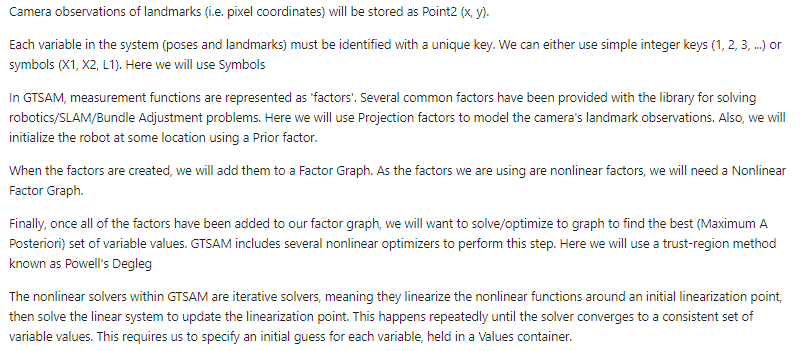

In [23]:
import gtsam
from gtsam import symbol_shorthand

from gtsam import (Cal3_S2, DoglegOptimizer,
                         GenericProjectionFactorCal3_S2, Marginals,
                         NonlinearFactorGraph, PinholeCameraCal3_S2, Point3,
                         Pose3, PriorFactorPoint3, PriorFactorPose3, Rot3, Values)
from gtsam.utils import plot
from gtsam.examples import SFMdata

L = symbol_shorthand.L # L is the integer key for landmarks
X = symbol_shorthand.X # X is the integer key for poses

# Define the camera calibration parameters
gtsam_camera_matrix = gtsam.Cal3_S2(
    K[0, 0], K[1, 1], 0.0, K[0, 2], K[1, 2])

# Define the camera observation noise model
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)  # one pixel in u and v

In [24]:
Pose3(transformation_matrices[0])

R: [
	0.998272, -0.0114242, 0.0576399;
	0.0120137, 0.999879, -0.00989241;
	-0.0575199, 0.0105678, 0.998288
]
t: -0.436089  0.285699 -0.853348

In [25]:
# Create the set of ground-truth landmarks
# points = SFMdata.createPoints()
# print(points)

# print(total_points)

points = []
for pt in total_points:
    points.append(np.array(pt))

print(points)

[array([0., 0., 0.]), array([-19.64666176,  18.58084297,  31.40689468]), array([ 0.78131872, -0.91171664, 15.62978077]), array([ 0.48788744, -0.20171049,  3.12643194]), array([-10.34805393,  10.48037529,  19.22359467]), array([ 0.37183338, 10.56173325, 27.67410278]), array([-10.43860245,  10.6091938 ,  19.55625343]), array([ 0.31963992, 12.15545368, 21.78393555]), array([6.48210058e-03, 1.42975509e+00, 3.37511826e+01]), array([ 0.12963763, -1.19791877, 26.4606781 ]), array([-0.19044764, 11.61276627, 20.11989784]), array([-10.11361313,  10.48419571,  19.54533005]), array([-10.11361313,  10.48419571,  19.54533005]), array([-0.25679195, 11.4025631 , 20.48745537]), array([-0.25679195, 11.4025631 , 20.48745537]), array([-0.27121946, 11.43397427, 20.55801964]), array([-10.19935513,  10.19354725,  19.90501595]), array([-0.2651805 , 11.58204651, 20.11072159]), array([-0.2710211 , 11.514534  , 20.09268951]), array([-9.97352695, 10.37965298, 19.98884583]), array([-9.95246887, 10.3621769 , 19.957

In [26]:
K = Cal3_S2(50.0, 50.0, 0.0, 50.0, 50.0)
# Create the set of ground-truth poses
poses = SFMdata.createPoses(K)
print(poses)

[R: [
	0, 0.242536, -0.970143;
	1, -0, 0;
	-0, -0.970143, -0.242536
]
t: 40  0 10
, R: [
	-0.707107, 0.171499, -0.685994;
	0.707107, 0.171499, -0.685994;
	0, -0.970143, -0.242536
]
t: 28.2843 28.2843      10
, R: [
	-1, 1.4851e-17, -5.94041e-17;
	6.12323e-17, 0.242536, -0.970143;
	0, -0.970143, -0.242536
]
t: 2.44929e-15          40          10
, R: [
	-0.707107, -0.171499, 0.685994;
	-0.707107, 0.171499, -0.685994;
	0, -0.970143, -0.242536
]
t: -28.2843  28.2843       10
, R: [
	-1.22465e-16, -0.242536, 0.970143;
	-1, 2.9702e-17, -1.18808e-16;
	0, -0.970143, -0.242536
]
t:         -40 4.89859e-15          10
, R: [
	0.707107, -0.171499, 0.685994;
	-0.707107, -0.171499, 0.685994;
	0, -0.970143, -0.242536
]
t: -28.2843 -28.2843       10
, R: [
	1, -4.45531e-17, 1.78212e-16;
	-1.83697e-16, -0.242536, 0.970143;
	0, -0.970143, -0.242536
]
t: -7.34788e-15          -40           10
, R: [
	0.707107, 0.171499, -0.685994;
	0.707107, -0.171499, 0.685994;
	-0, -0.970143, -0.242536
]
t:  28.2843 

In [27]:
poses = []
for t in transformation_matrices:
    poses.append(Pose3(t))

# Create the set of ground-truth poses
# poses = SFMdata.createPoses(K)

# print(my_poses)

In [32]:
# Create a factor graph
graph = NonlinearFactorGraph()

# Add a prior on pose x1. This indirectly specifies where the origin is.
# 0.3 rad std on roll,pitch,yaw and 0.1m on x,y,z
pose_noise = gtsam.noiseModel.Diagonal.Sigmas(
     np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))
factor = PriorFactorPose3(X(0), poses[0], pose_noise)
graph.push_back(factor)

# Simulated measurements from each camera pose, adding them to the factor graph
for i, pose in enumerate(poses):
    camera = PinholeCameraCal3_S2(pose, K)
    for j, point in enumerate(points):
        try:
            measurement = camera.project(point)
            factor = GenericProjectionFactorCal3_S2(
                measurement, measurement_noise, X(i), L(j), K)
            graph.push_back(factor)
        except RuntimeError:
            print("cheirality exception caught!")
            continue
        

cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exception caught!
cheirality exc

In [33]:
point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
factor = PriorFactorPoint3(L(0), points[0], point_noise)
graph.push_back(factor)
# graph.print('Factor Graph:\n')

In [34]:
initial_estimate = Values()
for i, pose in enumerate(poses):
    transformed_pose = pose.retract(0.1*np.random.randn(6, 1))
    initial_estimate.insert(X(i), transformed_pose)
for j, point in enumerate(points):
    transformed_point = point + 0.1*np.random.randn(3)
    initial_estimate.insert(L(j), transformed_point)
initial_estimate.print('Initial Estimates:\n')

Initial Estimates:

Values with 7640 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-0.0408377;
	-0.12682;
	-0.0142378
]

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-19.5675;
	18.6449;
	31.3857
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	0.745511;
	-0.921129;
	15.6693
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	0.334447;
	-0.100606;
	3.23153
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-10.3346;
	10.5674;
	19.0961
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	0.475957;
	10.5732;
	27.686
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-10.4479;
	10.6165;
	19.6846
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	0.466162;
	12.3032;
	21.7328
]

Value l8: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	0.0219721;
	1.46022;
	33.7395
]

Value l9: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	0.335621;
	-1.14966;
	26.5156
]

Value l10: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-0.119197;
	11.6472;
	20.2308

In [35]:
# May need to run code above until no error happens...
params = gtsam.DoglegParams()
params.setVerbosity('TERMINATION')
optimizer = DoglegOptimizer(graph, initial_estimate, params)
print('Optimizing:')
result = optimizer.optimize()
result.print('Final results:\n')
print('initial error = {}'.format(graph.error(initial_estimate)))
print('final error = {}'.format(graph.error(result)))

Optimizing:
convergedFinal results:

Values with 7640 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-0.0408072761991;
	-0.126715285513;
	-0.0142241161249
]

errorThreshold: 7.29351e+07 <? 0
absoluteDecrease: 0 <? 1e-05
relativeDecrease: 0 <? 1e-05
iterations: 11 >? 100

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-19.5596285857;
	18.6362015214;
	31.3772895304
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	0.745366821279;
	-0.92162278333;
	15.6639686576
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	0.334272874655;
	-0.100674803792;
	3.23051476565
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-10.3312516776;
	10.5626191674;
	19.0908126531
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	0.476419003343;
	10.5677292931;
	27.6762119283
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-10.4444097436;
	10.6117351823;
	19.6789134174
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	0.466215511722;
	12.2976469286;


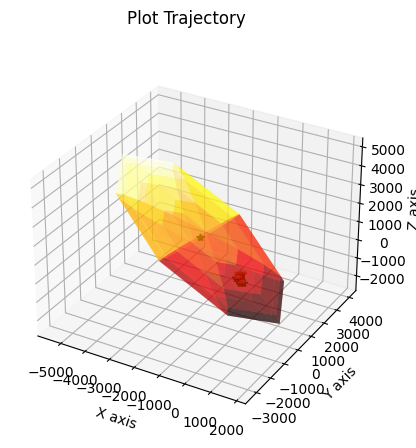

In [ ]:
# marginals = Marginals(graph, result)
# plot.plot_3d_points(1, result, marginals=marginals)
# plot.plot_trajectory(1, result, marginals=marginals, scale=8)
# plot.set_axes_equal(1)
# plt.show()

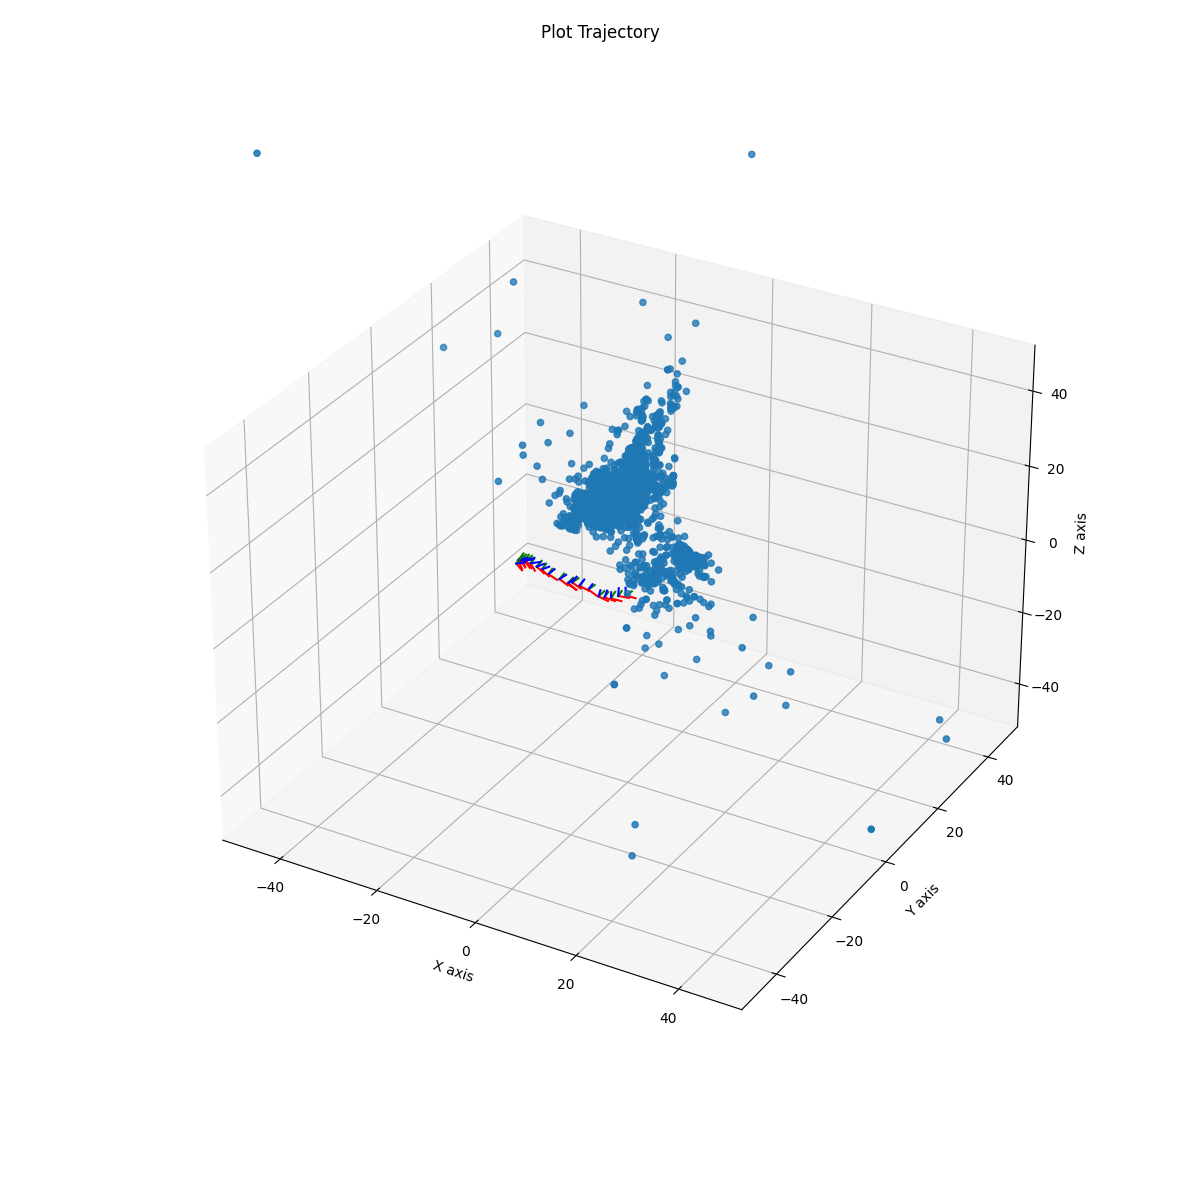

In [36]:
# %matplotlib qt
%matplotlib ipympl
import matplotlib.pyplot as plt 


fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection='3d')
# gtsam.utils.plot.plot_3d_points(1, result)
gtsam.utils.plot.plot_trajectory(1, result, scale=2)
gtsam.utils.plot.set_axes_equal(1)

xPts = [pt_cloud[0] for pt_cloud in points]
yPts = [pt_cloud[1] for pt_cloud in points]
zPts = [pt_cloud[2] for pt_cloud in points]

ax.scatter(xPts, yPts, zPts)

ax.set_xlim3d(-50, 50)
ax.set_ylim3d(-50, 50)
ax.set_zlim3d(-50, 50)

plt.show()

In [ ]:
# noise for 3D points because of scale ambiguity
point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

graph = gtsam.NonlinearFactorGraph()

initial = gtsam.Values()

In [ ]:
# Convert from the transformation matrix to the projection matrix.
def get_projection_matrix(transformation_matrix):
    return K.dot(np.linalg.inv(transformation_matrix)[:3])

pose_factor = gtsam.PriorFactorPose3(X(0), gtsam.Pose3(), pose_noise)
graph.push_back(pose_factor)

In [ ]:
# Get projection matrices for each transformation matrix
proj_matList = []
for transformation in pose_array:
    projection_matrix = get_projection_matrix(transformation)
    proj_matList.append(projection_matrix)

# Start adding a prior on the position of the first landmark. This fixes the scale ambiguity of the SFM problem
point_factor = gtsam.PriorFactorPoint3(L(0), pt_cloud_indexed[0].coords, point_noise)
graph.push_back(point_factor)

In [ ]:
# Convert 3D points to GTSAM Point3 objects
def createGtsamPoint(pt_3d):
    return gtsam.Point3(pt_3d[0],pt_3d[1],pt_3d[2])

createGtsamPoint(pt_cloud_indexed[3].coords)

array([-5.36505604, -2.27756572, 18.46234322])

In [ ]:
# Add simulatied camera pose
for j, pt_cloud_object in enumerate(pt_cloud_indexed):
    point = createGtsamPoint(pt_cloud_object.coords)
    measurements = list(pt_cloud_object.origin.values())
    for i, poseIndex in enumerate(list(pt_cloud_object.origin.keys())):
        p = gtsam.Pose3(gtsam.Rot3(pose_array[poseIndex][:3,:3]), gtsam.Point3(pose_array[poseIndex][:3,3].flatten()))
        camera = PinholeCameraCal3_S2(p, gtsam_camera_matrix)
        try:
            measurement = measurements[i]
            
            factor = GenericProjectionFactorCal3_S2(
                measurement, measurement_noise, X(poseIndex), L(j), gtsam_camera_matrix)
            graph.push_back(factor)
        except RuntimeError:
            print("cheirality exception caught!")
            continue

In [ ]:
# ground truth V2
# gtsam data structure generation for ground truth
#initial_estimate = Values()

for i, pose in enumerate(pose_array):
    p = gtsam.Pose3(gtsam.Rot3(pose[:3,:3]), gtsam.Point3(pose[:3,3].flatten()))
    #transformed_pose = p.retract(0.1*np.random.randn(6,1))
    initial.insert(X(i), p)

# check this
# use pose with the most 3d points as the ground truth landmark list
for j, pt_cloud_object in enumerate(pt_cloud_indexed):
    point = createGtsamPoint(pt_cloud_object.coords)
    #transformed_point = point + 0.1*np.random.randn(3)
    initial.insert(L(j), point)

In [ ]:
 # Optimize the graph and print results
#params = gtsam.DoglegParams()
params = gtsam.LevenbergMarquardtParams()

#params.setVerbosity('TERMINATION')
#params.setDeltaInitial(10.0)
#optimizer = DoglegOptimizer(graph, initial, params)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

print('Optimizing:')
result = optimizer.optimize()
result.print('Final results:\n')
print('initial error = {}'.format(graph.error(initial)))
print('final error = {}'.format(graph.error(result)))

Optimizing:
Final results:

Values with 4702 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-15.3545;
	11.1646;
	11.1435
]

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-17.1006;
	12.4876;
	14.4931
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-17.1579;
	12.5335;
	14.6112
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-5.57077;
	-10.1456;
	23.5629
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-5.20193;
	-8.55066;
	18.991
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-16.9773;
	12.2679;
	14.7731
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-16.9525;
	12.5593;
	14.7906
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-16.96;
	12.5667;
	14.8212
]

Value l8: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-16.7179;
	10.8698;
	15.2773
]

Value l9: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-9.66324;
	17.8596;
	11.6105
]

Value l10: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-16.7392;
	10.8873;
	15.3986
]

V

In [ ]:
 # Optimize the graph and print results
#params = gtsam.DoglegParams()
params = gtsam.LevenbergMarquardtParams()

#params.setVerbosity('TERMINATION')
#params.setDeltaInitial(10.0)
#optimizer = DoglegOptimizer(graph, initial, params)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, result, params)

print('Optimizing:')
result = optimizer.optimize()
result.print('Final results:\n')
print('initial error = {}'.format(graph.error(initial)))
print('final error = {}'.format(graph.error(result)))

Optimizing:
Final results:

Values with 4702 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-15.3545;
	11.1646;
	11.1435
]

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-17.1006;
	12.4876;
	14.4931
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-17.1579;
	12.5335;
	14.6112
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-5.57077;
	-10.1456;
	23.5629
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-5.20193;
	-8.55066;
	18.991
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-16.9773;
	12.2679;
	14.7731
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-16.9525;
	12.5593;
	14.7906
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-16.96;
	12.5667;
	14.8212
]

Value l8: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-16.7179;
	10.8698;
	15.2773
]

Value l9: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-9.66324;
	17.8596;
	11.6105
]

Value l10: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-16.7392;
	10.8873;
	15.3986
]

V

In [ ]:
pt_cloud_indexed[0].origin.values()

dict_values([array([  41.487427, 1536.5966  ], dtype=float32), array([  60.980595, 1559.1638  ], dtype=float32)])

In [ ]:
count = 0

    
print(count)
print(len(pt_cloud_indexed))

print('initial error = {}'.format(graph.error(initial)))

print('final error = {}'.format(graph.error(result)))

0
4680
initial error = 4011973282.045551
final error = 102789055.17943677


In [ ]:
# graph.saveGraph('graph_bundled.dot')

In [ ]:

# marginals = Marginals(graph, result)
# plot.plot_3d_points(1, result, marginals=marginals)
# plot.plot_trajectory(1, result, marginals=marginals, scale=8)
# plot.set_axes_equal(1)
# plt.show()

In [ ]:
def colorPoints(pt_cloud_final):
    point_color_list = []
    for pt_cloud in pt_cloud_indexed:
        img_index_list = list(pt_cloud.origin.keys())
        coords_2d = list(pt_cloud.origin.values())
        bFinal = 0
        gFinal = 0
        rFinal = 0
        for i, img_index in enumerate(img_index_list):
            #print(coords_2d[i])
            #print(coords)
            # image location is imgs[y,x]
            r,g,b = (imgs[img_index][coords_2d[i][1].astype(int), coords_2d[i][0].astype(int)])
            bFinal += b
            gFinal += g
            rFinal += r

        # average color over number of images that it was seen in
        bFinal /= len(img_index_list)
        gFinal /= len(img_index_list)
        rFinal /= len(img_index_list)
        point_color_list.append([rFinal,gFinal,bFinal])
    point_color_list = np.array(point_color_list)
    return point_color_list

In [ ]:
pt_cloud_final = [pt_cloud.coords for pt_cloud in pt_cloud_indexed]
print(pt_cloud_final)
point_color_list = colorPoints(pt_cloud_final)

[array([-8.655443,  9.39287 , 15.078628], dtype=float32), array([-8.655443,  9.39287 , 15.078628], dtype=float32), array([-8.658848,  9.397175, 15.08583 ], dtype=float32), array([-5.365056 , -2.2775657, 18.462343 ], dtype=float32), array([-5.365056 , -2.2775657, 18.462343 ], dtype=float32), array([-8.724522,  9.370964, 15.379269], dtype=float32), array([-8.592676,  9.423679, 15.237202], dtype=float32), array([-8.579913,  9.410192, 15.221862], dtype=float32), array([-9.107298,  8.95684 , 16.227825], dtype=float32), array([-9.049795,  8.900213, 16.161484], dtype=float32), array([-9.092648,  8.984265, 16.400354], dtype=float32), array([-5.2654   , -2.8030684, 18.21172  ], dtype=float32), array([-5.2654   , -2.8030684, 18.21172  ], dtype=float32), array([-5.077742, -2.069719, 17.709648], dtype=float32), array([-5.347054, -2.286168, 18.70103 ], dtype=float32), array([-5.222628 , -2.2391698, 18.317493 ], dtype=float32), array([-5.256413 , -2.2519765, 18.513615 ], dtype=float32), array([-5.26

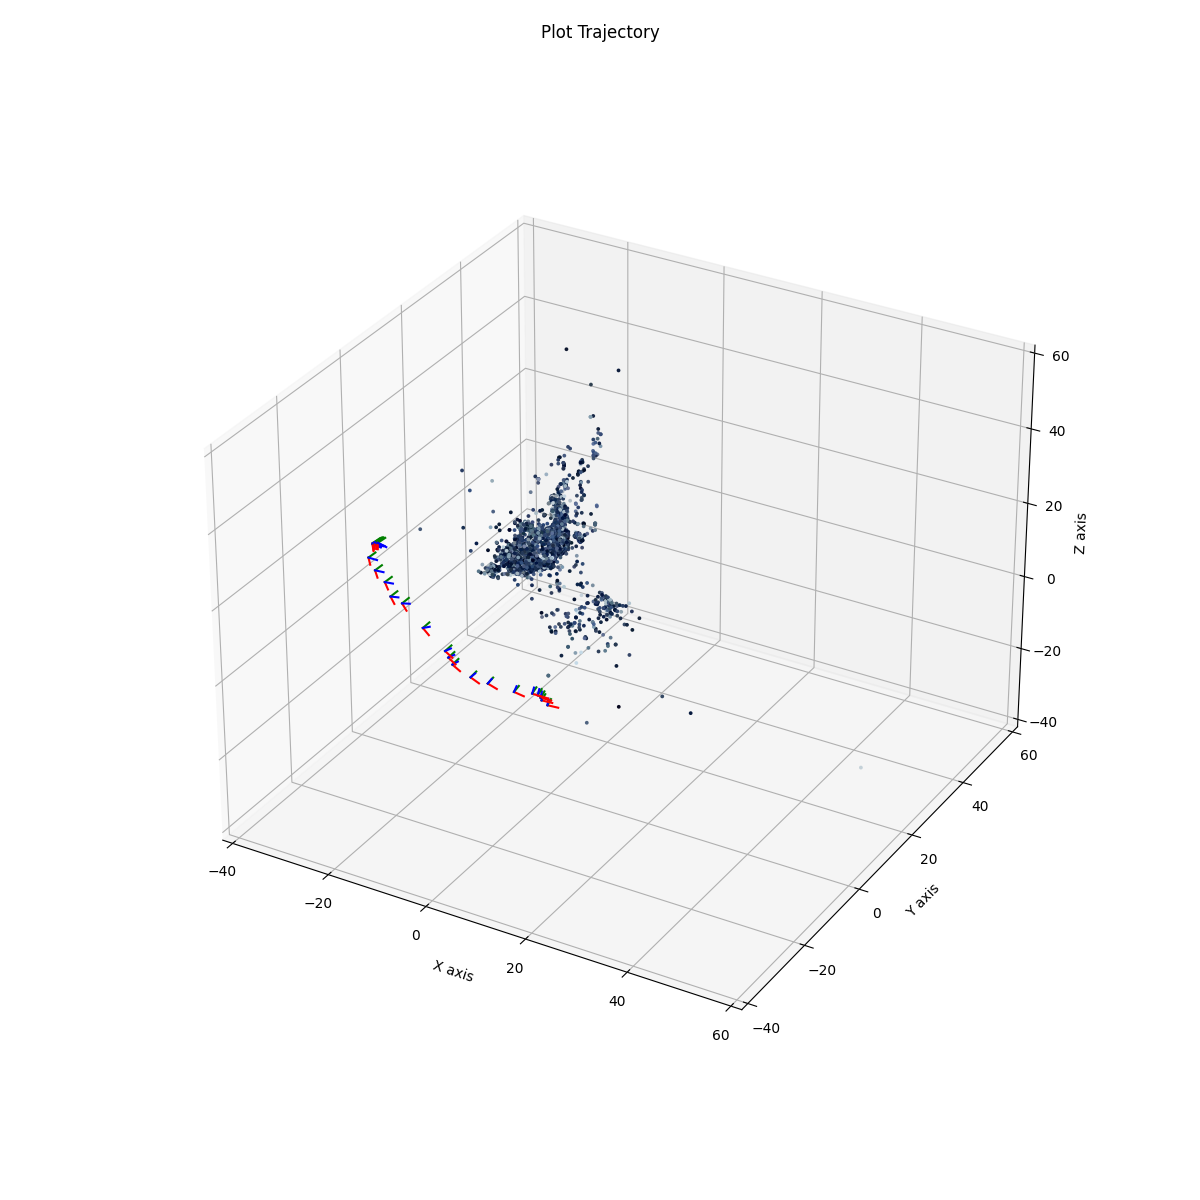

In [ ]:
# %matplotlib qt
%matplotlib ipympl
import matplotlib.pyplot as plt 


fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection='3d')
# gtsam.utils.plot.plot_3d_points(1, result)
gtsam.utils.plot.plot_trajectory(1, result, scale=2)
gtsam.utils.plot.set_axes_equal(1)

xPts = [pt_cloud[0] for pt_cloud in pt_cloud_final]
yPts = [pt_cloud[1] for pt_cloud in pt_cloud_final]
zPts = [pt_cloud[2] for pt_cloud in pt_cloud_final]

ax.scatter(xPts, yPts, zPts, s=3, c = point_color_list/255.)

ax.set_xlim3d(-40, 60)
ax.set_ylim3d(-40, 60)
ax.set_zlim3d(-40, 60)

plt.show()